In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import itertools
from networkx.algorithms.community import girvan_newman, modularity
import networkx.algorithms.community as nxcom
from pprint import pprint as pp
from sklearn.preprocessing import MinMaxScaler
from scipy import signal
from scipy.spatial.distance import squareform, pdist
import seaborn as sns

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving trading_floor.xml to trading_floor.xml


Reading Data to plot a graph

In [ ]:
    G = nx.read_graphml('trading_floor.xml')

(-1.20308536303299,
 1.1372316776328955,
 -1.0867898681532933,
 1.0417950156450881)

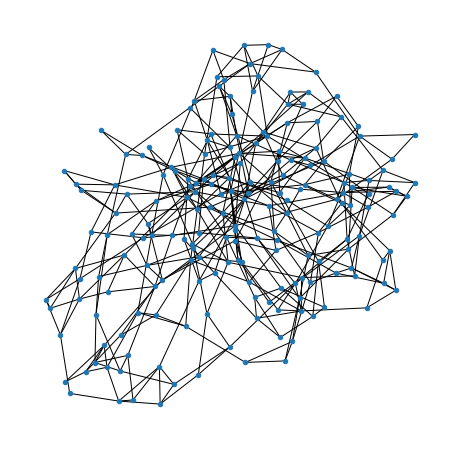

In [ ]:
# Initial visualisation of the graph
fig = plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G)
nx.draw_networkx(G,
        pos=(pos),
        node_size=20,
        with_labels=False)
plt.axis("off")

Calculating degree stats

In [ ]:
#Degree Centrality
deg_cent = nx.degree_centrality(G)

#Betweenness Centrality
bet_cent = nx.betweenness_centrality(G)

#Eigenvector Centrality
eigen_cent = nx.eigenvector_centrality(G)

#Result visualisation

degree_data = pd.DataFrame({'degree centrality': deg_cent, 'betweenness centrality': bet_cent, 'eigenvector centrality': eigen_cent})

#Correlation matrix
degree_data.corr()

,degree centrality,betweenness centrality,eigenvector centrality
degree centrality,1.000000,0.736532,0.676837
betweenness centrality,0.736532,1.000000,0.641171
eigenvector centrality,0.676837,0.641171,1.000000


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


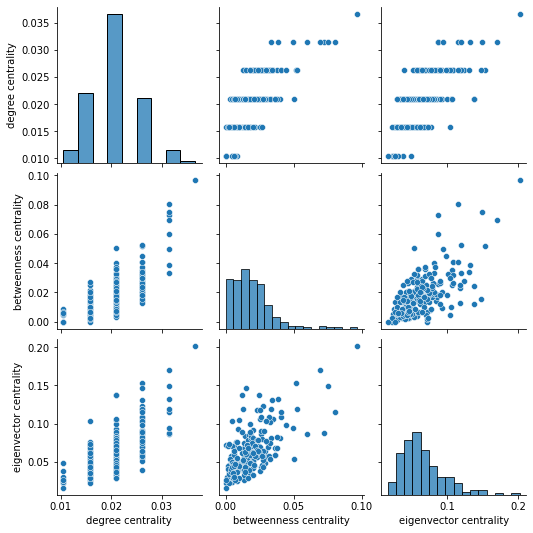

In [ ]:
#Scatter plot matrix
sns.pairplot(degree_data)

In [ ]:
#Summary Stats

degree_value = dict(G.degree())
degree_distribution = list(degree_value.values())
print("""
==============================================
    Summary stats on degree distribution
==============================================
Mu    :       {:.3f}
Min   :       {:>5}
Max   :       {:>5}
Sigma :       {:.3f}
""".format(np.mean(degree_distribution),
           np.min(degree_distribution),
           np.max(degree_distribution),
           np.std(degree_distribution))
     )


    Summary stats on degree distribution
Mu    :       4.000
Min   :           2
Max   :           7
Sigma :       0.901



Communities

In [ ]:
communities = sorted(nxcom.greedy_modularity_communities(G), key=len, reverse=True)
# Count the communities
print(f"The Exchange has {len(communities)} communities.")

The Exchange has 13 communities.


In [ ]:
#Node attribute dataframe

node_attr = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
node_attr['pos'] = tuple(zip(*node_attr[['x_pos','y_pos']].values.T))
scaler = MinMaxScaler()
node_attr['AI scaled'] = scaler.fit_transform(node_attr[['ai']])
node_attr

,ai,x_pos,y_pos,pos,AI scaled
0,4,1,0,"(1, 0)",0.4
1,4,1,1,"(1, 1)",0.4
2,4,1,2,"(1, 2)",0.4
3,4,1,3,"(1, 3)",0.4
4,7,1,4,"(1, 4)",0.7
...,...,...,...,...,...
187,10,22,11,"(22, 11)",1.0
188,0,22,12,"(22, 12)",0.0
189,8,22,13,"(22, 13)",0.8
190,9,22,14,"(22, 14)",0.9


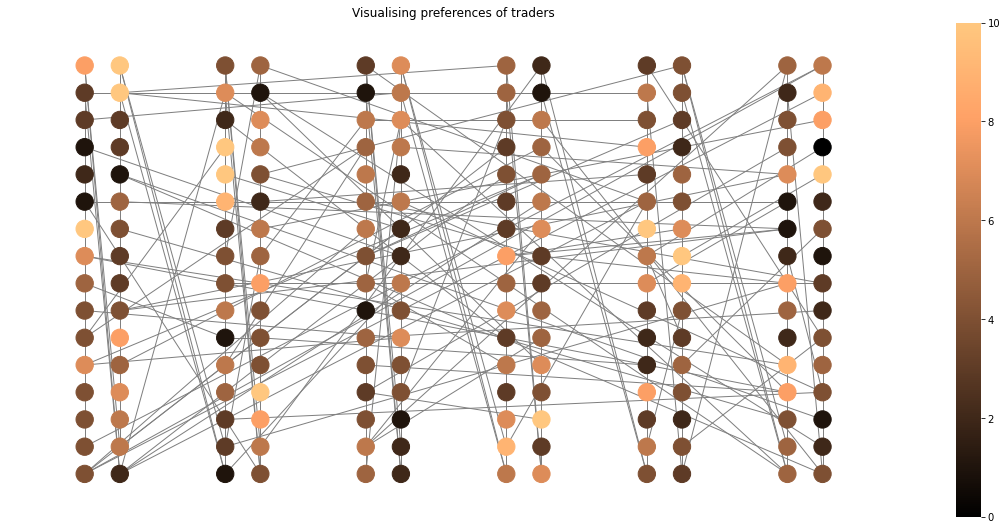

In [ ]:
# Visualising the traders by their position on the floor and distinguishing them by their preference to AI
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(2,1,1)
vmax = node_attr['ai'].max()
vmin = node_attr['ai'].min()
ax1.set_title('Visualising preferences of traders')
nx.draw_networkx(G,
                 pos=node_attr['pos'],
                 node_color=node_attr['ai'],
                 with_labels=False,
                 cmap='copper',
                 edge_color="grey",
                 ax=ax1)

c_b = plt.cm.ScalarMappable(cmap='copper',
                           norm=plt.Normalize(vmin=vmin, vmax=vmax))

plt.axis('off')
cbar = plt.colorbar(c_b)
cbar.outline.set_visible(False)

In [ ]:
#Payoff Dataframe
payoff_df = node_attr.drop(['ai', 'x_pos', 'y_pos', 'pos'], axis=1)
payoff_df['ec'] = scaler.fit_transform(degree_data[['eigenvector centrality']])
payoff_df

,AI scaled,ec
0,0.4,0.144569
1,0.4,0.048448
2,0.4,0.069556
3,0.4,0.134073
4,0.7,0.223761
...,...,...
187,1.0,0.174948
188,0.0,0.241821
189,0.8,0.163089
190,0.9,0.148792


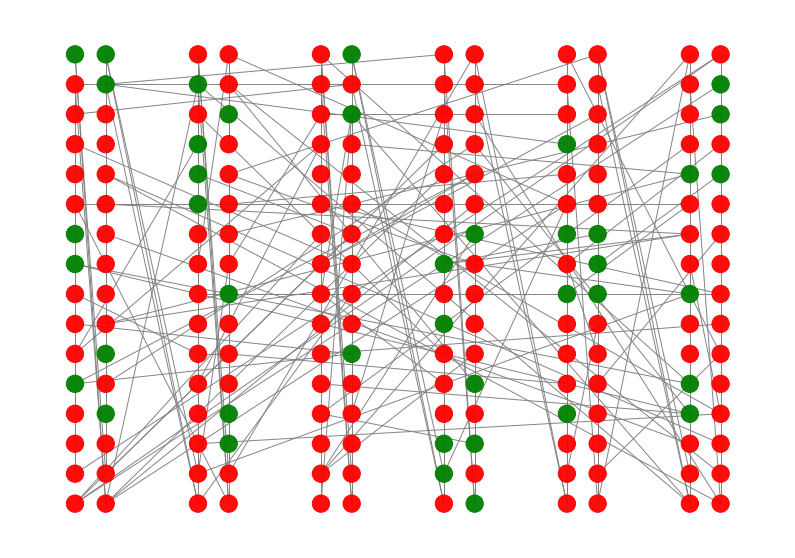

In [ ]:
#Early Adopters

#Threshold
node_attr["Adopters"] = (node_attr["ai"] >= 7).astype(int)

a = node_attr['Adopters']
for i in sorted(G.nodes()):
   G.nodes[i]['adopting'] = a[i]

#visualising the positions of the early adopters

colors = []
for n in G.nodes():
    if G.nodes[n]['adopting'] == 1:
        colors.append('green')
    else:
        colors.append('red')


fig = plt.figure(figsize=(14,10))
nx.draw_networkx(G,
                 pos=node_attr['pos'],
                 edge_color='grey',
                 with_labels=False,
                 node_color=colors,
                 alpha=0.95)
plt.axis('off')
plt.show()

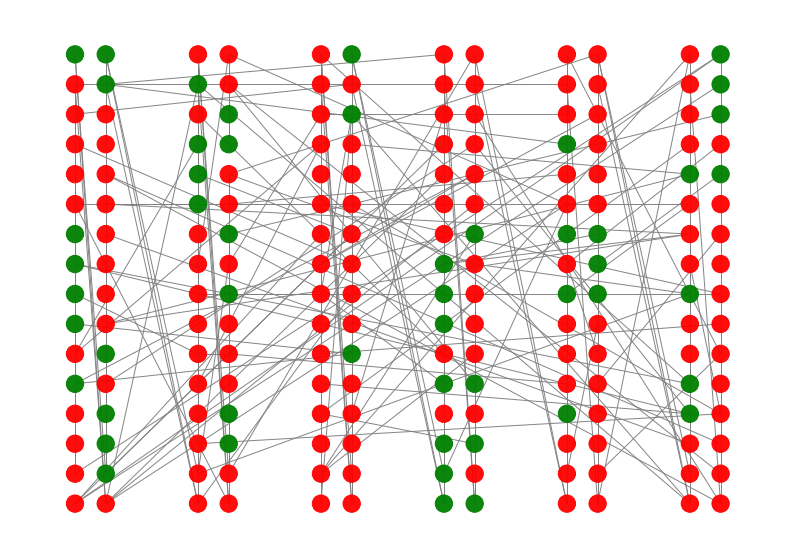

In [ ]:
for focal in G.nodes:
    a = ((payoff_df['AI scaled'].iloc[int(focal)]) * payoff_df['ec'].iloc[int(focal)])
    b = ((1.001-payoff_df['AI scaled'].iloc[int(focal)]) * payoff_df['ec'].iloc[int(focal)])#+ (1-payoff_df['ec'].iloc[int(focal)]) + (1-payoff_df['ai_scaled'].iloc[int(focal)])
    # count adopting neighbors
    focal_nbrs = list(G.neighbors(focal))
    p = np.sum([G.nodes[nbr]['adopting'] for nbr in focal_nbrs])# * payoff_df['ec'].iloc[int(focal)]
    # pay-off of adopting new behavior
    d = G.degree(focal)# * (np.max(payoff_df['ec']+0.001) - payoff_df['ec'].iloc[int(focal)])
    a_payoff = p * a #* d_df['eigenvector_centrality'].iloc[int(focal)] #*
    b_payoff = (d - p) * b #* d_df['eigenvector_centrality'].iloc[int(focal)]
    # decision to adopt
    if (G.nodes[focal]['adopting'] == 0) & (a_payoff > b_payoff):
        G.nodes[focal]['adopting'] = 1
#        adopters.extend(focal)
    else:
        pass

colors = []
for n in G.nodes():
    if G.nodes[n]['adopting'] == 1:
        colors.append('green')

    else:
        colors.append('red')

fig = plt.figure(figsize=(14,10))
nx.draw_networkx(G,
                 pos=node_attr['pos'],
                 edge_color='grey',
                 with_labels=False,
                 node_color=colors,
                 cmap=plt.cm.coolwarm,
                 alpha=0.95)
plt.axis('off')
plt.show()

In [ ]:
adoption_rate = nx.get_node_attributes(G, 'adopting')
adoption = []
for i in adoption_rate.values():
    adoption.append(i)

np.mean(adoption)

0.21354166666666666